In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import scipy
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
import random


In [3]:
carsdata=pd.read_csv('car_price.csv', usecols=range(1, 10))
carsdata.sample(5)

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
3906,Mahindra Scorpio S5 BSIV,8.75 Lakh,"1,20,000 kms",Diesel,Manual,2nd Owner,2018,1598 cc,5 Seats
4044,Hyundai EON Era Plus,2.21 Lakh,"45,039 kms",Petrol,Manual,1st Owner,2015,998 cc,5 Seats
1300,Toyota Fortuner 2.8 4WD MT BSIV,24.45 Lakh,"1,00,000 kms",Diesel,Manual,1st Owner,2017,1498 cc,5 Seats
3944,Hyundai i20 Active 1.2 S,5.14 Lakh,"73,891 kms",Petrol,Manual,1st Owner,2017,936 cc,5 Seats
4713,Hyundai i20 Petrol CVT Asta,6.82 Lakh,"48,953 kms",Petrol,Automatic,2nd Owner,2018,1197 cc,5 Seats


<b>CHECKING NULL VALUES</B>

In [4]:
carsdata.isnull().sum()

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

<b> ADJUSTING NUMERIC VALUES AND CHANGING PRICE TO USD</B>

In [5]:
exchange_rate = 1203 # 100000 ruppes to dolars
carsdata["price_in_USD"] = [float(i[:-5])*exchange_rate for i in carsdata["car_prices_in_rupee"]]
carsdata["kms_driven"] = [float(i[:-4].replace(",","")) for i in carsdata["kms_driven"]]
carsdata["engine"] = [float(i[:-3]) for i in carsdata["engine"]]
carsdata["Seats"] = [float(i[:-6]) for i in carsdata["Seats"]]
carsdata.sample(5)


,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,price_in_USD
1392,Mahindra Scorpio S5 BSIV,9.98 Lakh,68307.0,Diesel,Manual,1st Owner,2018,1197.0,5.0,12005.94
4512,Mahindra XUV300 W8 Option Diesel,10.50 Lakh,65000.0,Diesel,Manual,1st Owner,2020,1995.0,5.0,12631.50
1969,Maruti Wagon R VXI BS IV,2.36 Lakh,100527.0,Petrol,Manual,1st Owner,2012,799.0,5.0,2839.08
2559,Hyundai EON Magna Plus,3.57 Lakh,5000.0,Petrol,Manual,1st Owner,2018,1198.0,5.0,4294.71
3715,BMW X3 xDrive 30i Luxury Line,61.75 Lakh,18000.0,Petrol,Automatic,1st Owner,2021,1396.0,5.0,74285.25


In [6]:
carsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_name             5512 non-null   object 
 1   car_prices_in_rupee  5512 non-null   object 
 2   kms_driven           5512 non-null   float64
 3   fuel_type            5512 non-null   object 
 4   transmission         5512 non-null   object 
 5   ownership            5512 non-null   object 
 6   manufacture          5512 non-null   int64  
 7   engine               5512 non-null   float64
 8   Seats                5512 non-null   float64
 9   price_in_USD         5512 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 430.8+ KB


<b> CHECKING CATEGORICAL VARIABLES </B>

In [7]:
print(carsdata["fuel_type"].unique())
print(carsdata["transmission"].unique())
print(carsdata["ownership"].unique())

['Diesel' 'Petrol' 'Cng' 'Electric' 'Lpg']
['Manual' 'Automatic']
['1st Owner' '2nd Owner' '3rd Owner' '4th Owner' '5th Owner' '0th Owner']


In [8]:
carsdata[carsdata["ownership"] == '0th Owner'].shape[0]

7

There are 7 registers described as '0th Owner'. We are removing those registers.

In [9]:
carsdata = carsdata.loc[carsdata["ownership"] != '0th Owner']

In [10]:
# OPTIONAL !!!!!
# carsdata = carsdata[carsdata["price_in_USD"]<14000]

<b> SPLIT DATASET (TRAIN - TEST) </B>

In [11]:
msk = np.random.rand(len(carsdata)) < 0.8
car_train = carsdata[msk]
car_test = carsdata[~msk]
len(car_train), len(car_test)

(4362, 1143)

<b> CHECKING FOR MULTICOLLINEARITY </B>

/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_81532/1607395212.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = car_train.corr().round(2)


<Axes: >

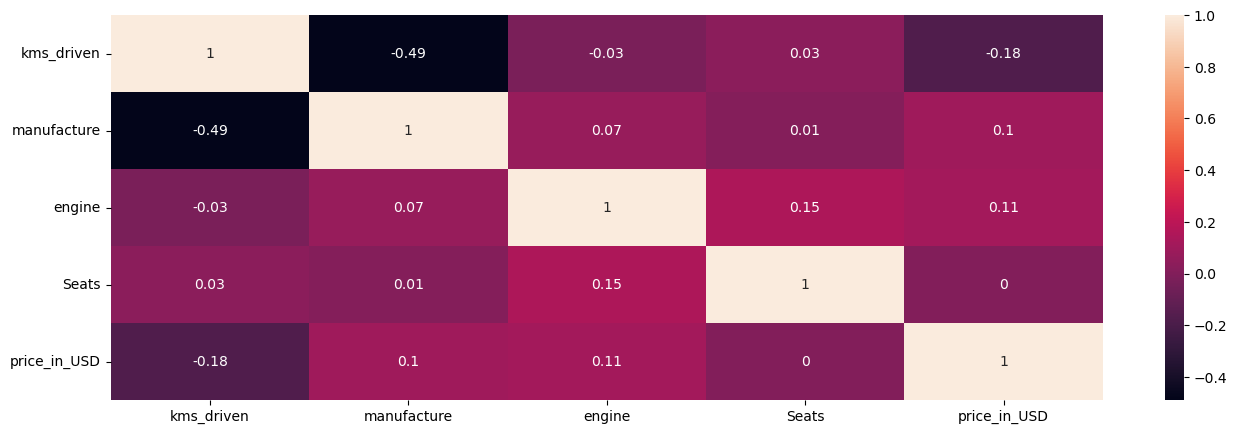

In [12]:
correlation_matrix = car_train.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [13]:
y, X = dmatrices('price_in_USD~kms_driven+manufacture+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)', data=car_train, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                   features
0   425857.407629                  Intercept
1       16.423265     C(fuel_type)[T.Diesel]
2        1.170148   C(fuel_type)[T.Electric]
3        1.343367        C(fuel_type)[T.Lpg]
4       16.432684     C(fuel_type)[T.Petrol]
5        1.166989  C(transmission)[T.Manual]
6        1.163649  C(ownership)[T.2nd Owner]
7        1.153384  C(ownership)[T.3rd Owner]
8        1.052113  C(ownership)[T.4th Owner]
9        1.013734  C(ownership)[T.5th Owner]
10       1.555914                 kms_driven
11       1.624514                manufacture
12       1.063190                     engine
13       1.027461                      Seats


Despite VIF is low, kms_driven and manufacture have a High negative correlation coeficient. which is not desirable for our model.
We will eliminate manufacture predictor

<b> MODELING 1A</B>

In [14]:
model1A = smf.ols('price_in_USD~kms_driven+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=car_train).fit()
model1A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_in_USD   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     93.58
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          1.81e-206
Time:                        03:03:31   Log-Likelihood:                -49025.
No. Observations:                4362   AIC:                         9.808e+04
Df Residuals:                    4349   BIC:                         9.816e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  2.483e+04   3109.867      7.985      0.000    1.87e+04    3.09e+04
C(fuel_type)[T.Diesel]     7487.5478   2275.211      3.291      0.001    3026.974    1.19e+04
C(fuel_type)[T.Electric]  -8122.4803   6017.652     -1.350      0.177   -1.99e+04    3675.184
C(fuel_type)[T.Lpg]        1.869e+04   4443.166      4.207      0.000    9979.836    2.74e+04
C(fuel_type)[T.Petrol]     2857.3697   2258.320      1.265      0.206   -1570.088    7284.827
C(transmission)[T.Manual] -1.707e+04    662.001    -25.786      0.000   -1.84e+04   -1.58e+04
C(ownership)[T.2nd Owner] -1596.1524    685.525     -2.328      0.020   -2940.132    -252.173
C(ownership)[T.3rd Owner]  -910.9404   1144.101     -0.796      0.426   -3153.961    1332.080
C(ownership)[T.4th Owner]  9072.1794   2334.029      3.887      0.000    4496.293    1.36e+04
C(ownership)[T.5th Owner]  2.473e+04   5853.677      4.225      0.000    1.33e+04    3.62e+04
kms_driven                   -0.0678      0.008     -8.888      0.000      -0.083      -0.053
engine                        1.1685      0.489      2.388      0.017       0.209       2.128
Seats                       -60.0830    390.392     -0.154      0.878    -825.451     705.285
==============================================================================
Omnibus:                     2896.594   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34424.308
Skew:                           3.099   Prob(JB):                         0.00
Kurtosis:                      15.288   Cond. No.                     1.76e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> CHECK FOR INFLUENTIAL POINTS </B>

In [15]:
infl = model1A.get_influence()

In [16]:
# Studentized external
n=model1A.nobs
p=13
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print(car_train.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([ 205,  238,  243,  283,  342,  368,  375,  531,  596,  607,
            ...
            5358, 5374, 5402, 5410, 5434, 5439, 5470, 5474, 5476, 5490],
           dtype='int64', length=221) [2.78964672 6.20240441 3.35851445 2.8763857  4.68800111 2.07598853
 1.97413955 2.45896471 4.42958389 2.76720961 3.0035246  3.42291009
 4.50217467 5.53408753 2.52128942 2.70382396 2.42751654 3.00829132
 3.31631597 2.01324558 2.18893461 2.95062291 3.35352106 2.23491156
 3.64257553 2.24416089 2.00674406 2.91545053 2.15927347 2.86169333
 3.87342422 5.2967991  2.01844784 6.10585204 2.35506171 3.08927144
 5.25494026 5.25261247 4.08243586 2.24329918 2.19603606 2.93832096
 2.09547816 2.34882644 4.57608032 3.04009052 3.29715023 3.129821
 2.12693428 4.13711896 2.93168504 2.72356774 3.6569676  2.24416089
 2.99190179 2.8137377  1.989478   2.15698819 2.82293571 2.54312643
 2.19717336 4.06821503 5.64448311 2.13739038 2.24912056 2.45914889
 3.0724348  3.31088213 4.68741617 2.03789152 3.15860152 4.13380226

In [17]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(car_train.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([ 205,  238,  243,  283,  288,  311,  342,  451,  596,  632,
            ...
            5284, 5318, 5329, 5346, 5358, 5374, 5402, 5439, 5470, 5474],
           dtype='int64', length=206) 205     0.001575
238     0.010708
243     0.003279
283     0.002171
288     0.002409
          ...   
5374    0.003282
5402    0.001011
5439    0.006891
5470    0.001095
5474    0.005289
Name: cooks_d, Length: 206, dtype: float64


In [18]:
# Common points
common = list(set(car_train.index[atyp_stud]) & set(car_train.index[atyp_cook]))
#Save Outliers for future analysis
mask = car_train.index.isin(common)
outliers = car_train[mask]


Let´s delete those influential points that has been identified by both methods

In [19]:
car_train = car_train.drop(common)

<b> MODELING 1B</B>

In [20]:
model1B = smf.ols('price_in_USD~kms_driven+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=car_train).fit()


<b> HETEROCEDASTICITY </B>


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

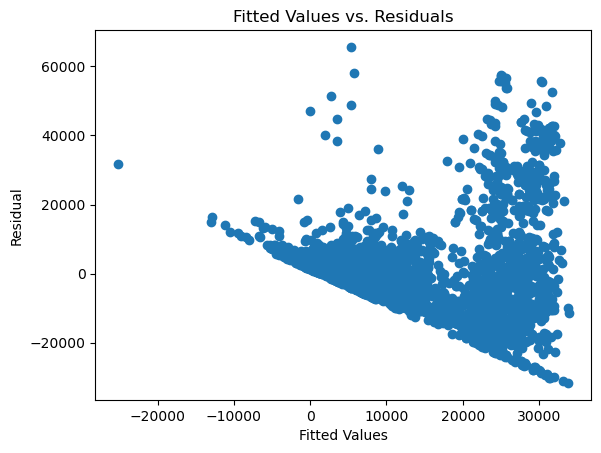

In [21]:
#Fitted Values vs. Residuals Plot
fitted1B = model1B.fittedvalues
res1B = model1B.resid
plt.scatter(fitted1B,res1B)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [22]:
#Breusch-Pagan test
bp_test = het_breuschpagan(model1B.resid, model1B.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 905.4995230884668, 'LM-Test p-value': 3.786159171426376e-186}


There is a significant evidence of heterocedasticity.

<b> NORMALITY</B>

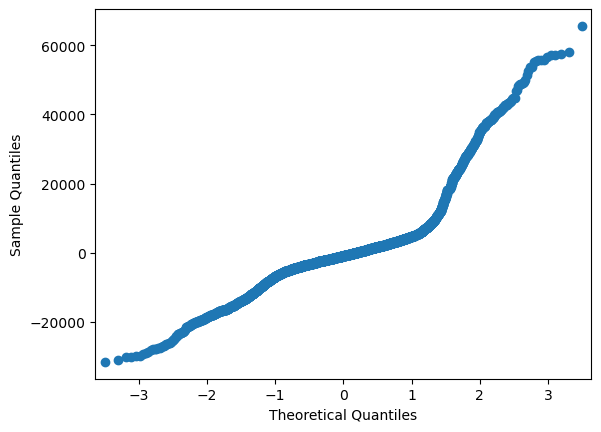

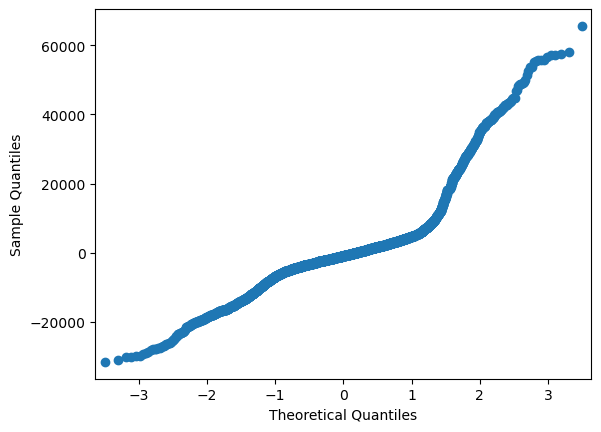

In [23]:
#qq plot
sm.qqplot(model1B.resid)

In [24]:
#jarque-Bera Test
jarque = stats.jarque_bera(res1B)
jarque.statistic

8263.265000207006

In [25]:
jarque.pvalue

0.0

There is a significant evidence of non-normality.

<b> NONLINEARITY BETWEEN X AND Y </B>

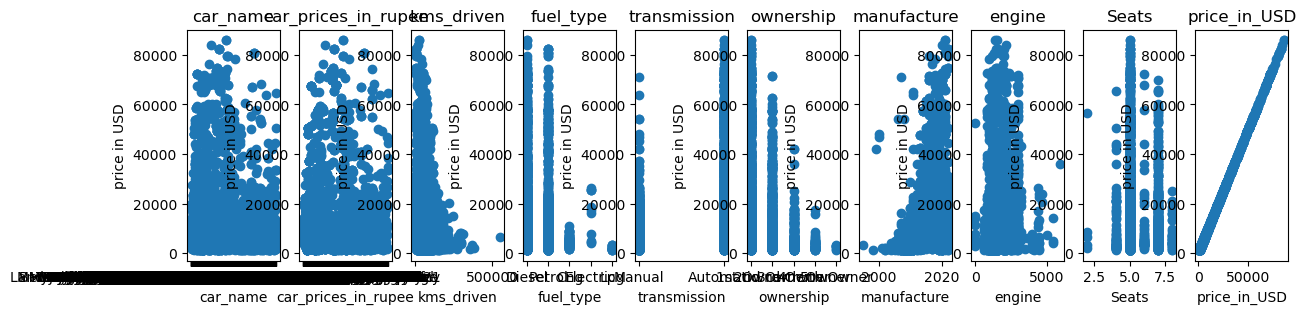

In [26]:
#pair-wise scatter plot between y and predictors
plt.figure(figsize=(20, 3))

for i, col in enumerate(car_train.columns):
    plt.subplot(1, 14, i+1)
    x = car_train[col]
    y = car_train['price_in_USD']
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price in USD')


<b> A TRANSFORMATION IS REQUIRED</B>

<b> OPTION 1: NATURAL-LOG TRANSFORMATION</B>

In [27]:
car_train['log_price']=np.log(car_train['price_in_USD'])

<b> MODELING 1C</B>

In [28]:
model1C = smf.ols('log_price~kms_driven+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=car_train).fit()
model1C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     347.7
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        03:03:57   Log-Likelihood:                -4176.1
No. Observations:                4209   AIC:                             8378.
Df Residuals:                    4196   BIC:                             8461.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     9.5798      0.111     85.993      0.000       9.361       9.798
C(fuel_type)[T.Diesel]        0.4933      0.081      6.108      0.000       0.335       0.652
C(fuel_type)[T.Electric]     -0.2280      0.214     -1.068      0.286      -0.647       0.191
C(fuel_type)[T.Lpg]          -0.6738      0.173     -3.891      0.000      -1.013      -0.334
C(fuel_type)[T.Petrol]       -0.0676      0.080     -0.843      0.399      -0.225       0.090
C(transmission)[T.Manual]    -0.9877      0.024    -41.468      0.000      -1.034      -0.941
C(ownership)[T.2nd Owner]    -0.2617      0.025    -10.595      0.000      -0.310      -0.213
C(ownership)[T.3rd Owner]    -0.5874      0.042    -14.053      0.000      -0.669      -0.505
C(ownership)[T.4th Owner]    -0.6469      0.091     -7.142      0.000      -0.825      -0.469
C(ownership)[T.5th Owner]    -0.6998      0.248     -2.823      0.005      -1.186      -0.214
kms_driven                -5.166e-06   2.76e-07    -18.729      0.000   -5.71e-06   -4.62e-06
engine                     6.641e-05   1.78e-05      3.723      0.000    3.14e-05       0.000
Seats                         0.0323      0.014      2.283      0.022       0.005       0.060
==============================================================================
Omnibus:                      326.529   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.517
Skew:                          -0.441   Prob(JB):                    2.28e-187
Kurtosis:                       5.031   Cond. No.                     1.87e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Fitted Values vs. Residuals after log transformation on y')

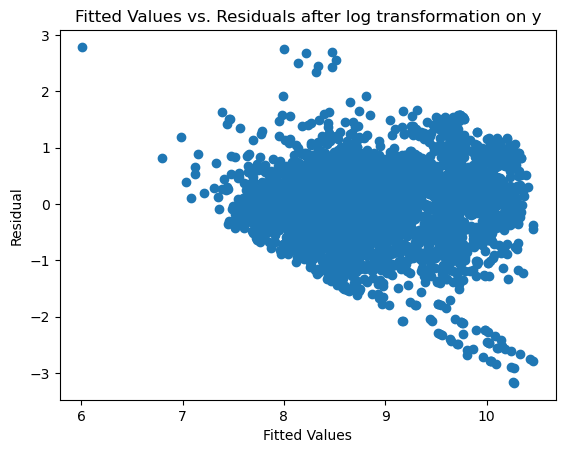

In [29]:
fitted1C = model1C.fittedvalues
res1C = model1C.resid
plt.scatter(fitted1C,res1C)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after log transformation on y")

<b> HETEROCEDASTICITY </B>


In [30]:
#Breusch-Pagan test
bp_test = het_breuschpagan(model1C.resid, model1C.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 261.84988759200843, 'LM-Test p-value': 4.599663040016838e-49}


Natural-Log transformation was not enough to eliminate heterocedasticity 

<b> NORMALITY</B>

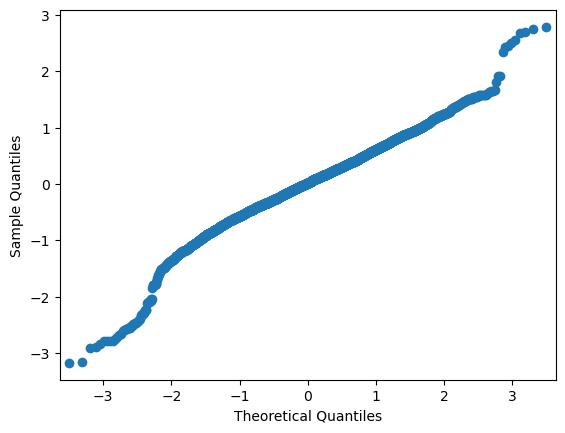

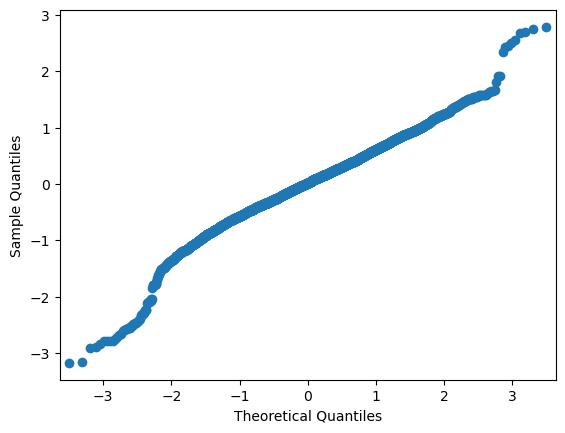

In [31]:
#qq plot
sm.qqplot(model1C.resid)

In [32]:
#jarque-Bera Test
jarque = stats.jarque_bera(res1C)
jarque.statistic

859.517472369733

In [33]:
jarque.pvalue

2.28114202339953e-187

Natural-Log transformation was not enough to eliminate non-normality

<b> NONLINEARITY BETWEEN X AND Y </B>

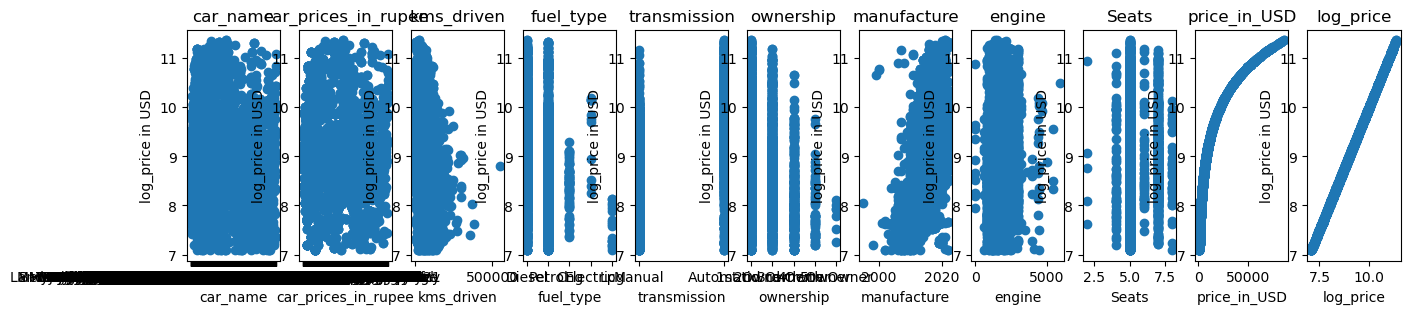

In [34]:
#pair-wise scatter plot between y and predictors
plt.figure(figsize=(20, 3))

for i, col in enumerate(car_train.columns):
    plt.subplot(1, 14, i+1)
    x = car_train[col]
    y = car_train['log_price']
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('log_price in USD')


<b> OPTION 2: BOX-COX TRANSFORMATION</B>

Lambda value used for Transformation: -0.22190994943234246


/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_81532/300639110.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(carsdata["price_in_USD"], hist = False, kde = True,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_81532/300639110.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seabo

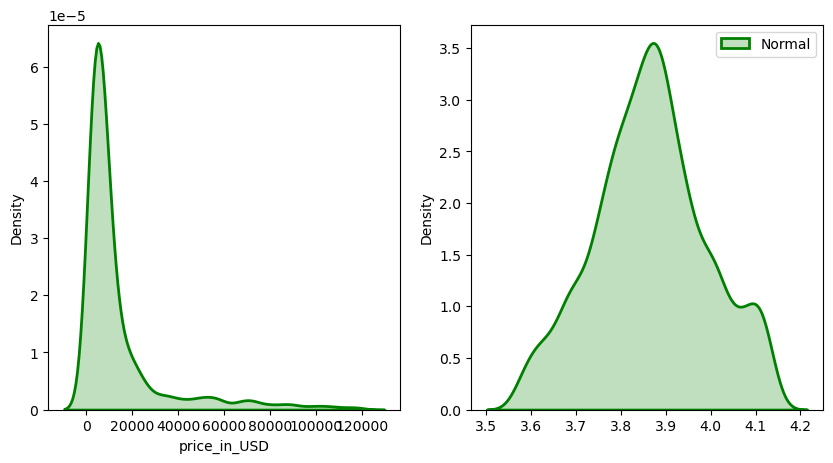

In [35]:
# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(car_train["price_in_USD"])

# adding the transformed Y to the dataframe 
car_train['box_price']=fitted_data

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(carsdata["price_in_USD"], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
 
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [36]:
model1D = smf.ols('box_price~kms_driven+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=car_train).fit()
model1D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              box_price   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     312.9
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        03:04:06   Log-Likelihood:                 4125.2
No. Observations:                4209   AIC:                            -8224.
Df Residuals:                    4196   BIC:                            -8142.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.9525      0.016    254.996      0.000       3.922       3.983
C(fuel_type)[T.Diesel]        0.0667      0.011      5.933      0.000       0.045       0.089
C(fuel_type)[T.Electric]     -0.0233      0.030     -0.783      0.434      -0.081       0.035
C(fuel_type)[T.Lpg]          -0.1182      0.024     -4.905      0.000      -0.165      -0.071
C(fuel_type)[T.Petrol]       -0.0106      0.011     -0.949      0.343      -0.032       0.011
C(transmission)[T.Manual]    -0.1234      0.003    -37.236      0.000      -0.130      -0.117
C(ownership)[T.2nd Owner]    -0.0378      0.003    -10.985      0.000      -0.044      -0.031
C(ownership)[T.3rd Owner]    -0.0881      0.006    -15.143      0.000      -0.099      -0.077
C(ownership)[T.4th Owner]    -0.1023      0.013     -8.117      0.000      -0.127      -0.078
C(ownership)[T.5th Owner]    -0.1124      0.034     -3.258      0.001      -0.180      -0.045
kms_driven                -7.032e-07   3.84e-08    -18.324      0.000   -7.78e-07   -6.28e-07
engine                     7.854e-06   2.48e-06      3.164      0.002    2.99e-06    1.27e-05
Seats                         0.0052      0.002      2.656      0.008       0.001       0.009
==============================================================================
Omnibus:                      617.015   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1493.315
Skew:                          -0.832   Prob(JB):                         0.00
Kurtosis:                       5.397   Cond. No.                     1.87e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Fitted Values vs. Residuals after Box-Cox transformation on y')

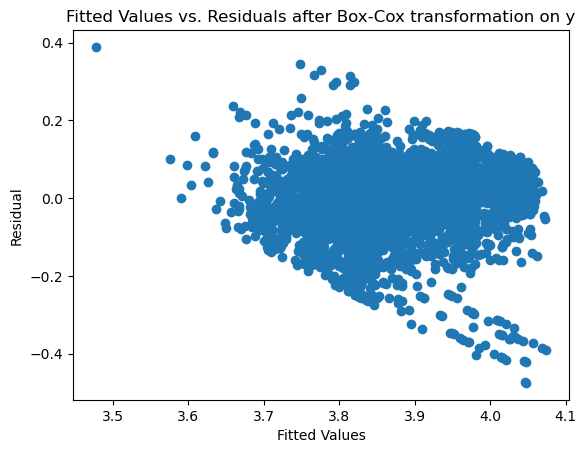

In [37]:
fitted1D = model1D.fittedvalues
res1D = model1D.resid
plt.scatter(fitted1D,res1D)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after Box-Cox transformation on y")

<b> HETEROCEDASTICITY </B>


In [38]:
#Breusch-Pagan test
bp_test = het_breuschpagan(model1D.resid, model1D.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 100.88056580877043, 'LM-Test p-value': 3.741997842433086e-16}


Box-Cox transformation was not enough to eliminate heterocedasticity

<b> NORMALITY</B>

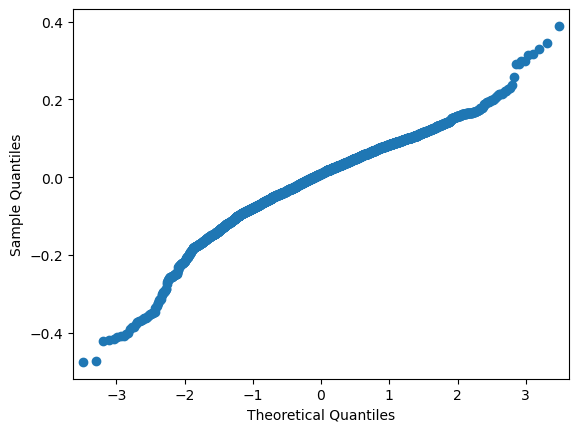

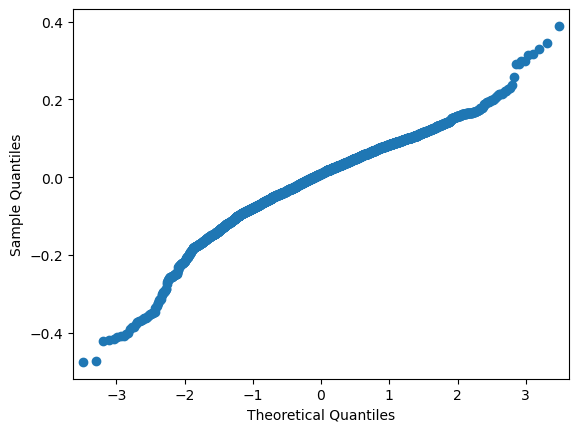

In [39]:
#qq plot
sm.qqplot(model1D.resid)

In [40]:
#jarque-Bera Test
jarque = stats.jarque_bera(res1D)
jarque.statistic

1493.315083912902

In [41]:
jarque.pvalue

0.0

<b> NONLINEARITY BETWEEN X AND Y </B>

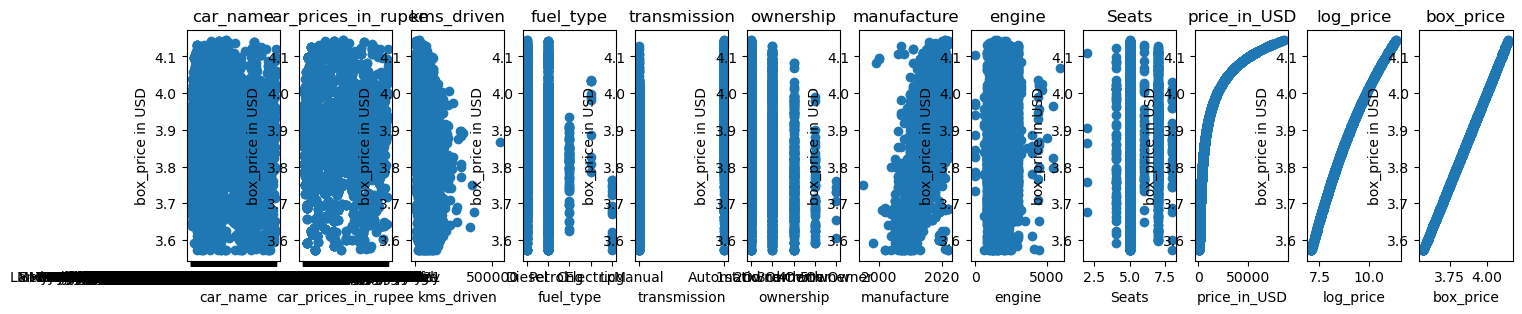

In [42]:
#pair-wise scatter plot between y and predictors
plt.figure(figsize=(20, 3))

for i, col in enumerate(car_train.columns):
    plt.subplot(1, 14, i+1)
    x = car_train[col]
    y = car_train['box_price']
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('box_price in USD')


<b> OPTION C: USE ROBUST STANDARD ERROR </B>

In [43]:
#extact HCE variance-coviance matrix
V_HC_1 =model1B.cov_HC0


In [44]:
print(np.round(model1B.get_robustcov_results(cov_type = "HC0").summary2().tables[1], 5))

                                 Coef.    Std.Err.         t    P>|t|  \
Intercept                  24815.15172  1370.35509  18.10856  0.00000   
C(fuel_type)[T.Diesel]      5527.22681   399.31203  13.84187  0.00000   
C(fuel_type)[T.Electric]   -8467.17727  2447.81886  -3.45907  0.00055   
C(fuel_type)[T.Lpg]        -1039.34442   697.77491  -1.48951  0.13643   
C(fuel_type)[T.Petrol]      -986.39837   362.79552  -2.71888  0.00658   
C(transmission)[T.Manual] -16294.62939   540.64746 -30.13910  0.00000   
C(ownership)[T.2nd Owner]  -2673.37892   364.18604  -7.34070  0.00000   
C(ownership)[T.3rd Owner]  -4847.61334   429.67704 -11.28199  0.00000   
C(ownership)[T.4th Owner]  -3460.65962   765.37896  -4.52150  0.00001   
C(ownership)[T.5th Owner]  -2705.44613   989.34323  -2.73459  0.00627   
kms_driven                    -0.06482     0.00506 -12.81358  0.00000   
engine                         1.20335     0.30839   3.90206  0.00010   
Seats                        -19.96226   213.32285 